# Cleaning & Exploratory Data Analysis of the checkouts data
This notebook is for initial exploration of the datasets associated with this challenge. 

## imports 

In [1]:
import os, sys, glob # for loading, saving and manipulating files on disk
from pathlib import Path # Path allows us to list directory paths in a manner that's not affected by the OS the notebook is being run on 

import pandas as pd # to work with csv files as dataframes 
import numpy as np # for mathematical and scientific computations 

import matplotlib.pyplot as plt # for plots 
import seaborn as sns # also for plotting, it's a wrapper for several matplotlib functions, making them more accessible 

## loading data

In [2]:
data_dir = Path.home()/'projects'/'billups_data_challenge'/'Data Challenge' # specifies the directory with data files
out_dir = data_dir.parent/'cleaned_data' # directory for storing intermediate outputs such as cleaned data
out_dir.mkdir(exist_ok=True) #creating the output directory, while making sure it's not overwritten if it already exists

In [3]:
checkouts_df = pd.read_csv(data_dir/'checkouts.csv')

## investigating the data

### visual inspection

In [4]:
checkouts_df.shape # checking the size of the data

(2000, 5)

In [5]:
checkouts_df.sample(10)

,id,patron_id,library_id,date_checkout,date_returned
274,4zqgXdITQuAC,6f476877ad84f711cab8e0b479342bbd,22d-222@5xc-kcy-8sq,2018-07-13,2018-07-29
1932,xSYmAQAAIAAJ,4520c746cf75798c777d0f0a1bacb62c,222-222@5xc-jvf-skf,2018-08-07,2018-08-30
217,PjQDAAAAQAAJ,f31c37f308a2c2d5fab3a1708b755f89,zzw-223@5xc-jv7-ct9,2018-01-19,2018-03-14
857,8XFFO-MK13QC,261c2ea208ea8ff8cf8a2a025ed1ab42,225-222@5xc-jtz-hkf,2018-06-08,2018-10-18
1458,Llg9AQAAMAAJ,91571672532fc1dfcd5fbd4fbc7bb178,zzw-222@5xc-knn-c5z,2018-09-30,2018-10-05
726,li4WAAAAYAAJ,566259c89e4d5edc761e04060cad965b,226-222@5xc-kc4-fpv,2018-11-20,2018-12-17
1140,0mt9NdDSmYYC,1f8362d8bae9cc98914182c97aad090e,zzw-223@5xc-jv7-ct9,2018-12-24,2019-03-27
738,mQTxAAAAMAAJ,5958ec75161d86b21964a51381fce4cb,223-222@5xc-jxr-tgk,2018-01-03,2018-01-09
542,59sDAAAAMBAJ,53abc8e29df808e9af1cc62ebbb9b433,22c-222@5xc-jwj-pvz,20180804,2018-08-29
1174,XNwDAAAAMBAJ,2ca512c5e312da61ad185088f3693ed7,226-222@5xc-kc4-fpv,2018-08-25,2018-09-16


Here are some characteristics that look concerning: 
- the date columns need to be formatted, as they have inappropriate characters such as '%'
- dates go as far back as 1800s in this sample itself, unsure if that's a recording error or if the libraries databases do have checkouts going that far back -- I did a quick check to see when the first library in Oregon came to be, and the 1800s are consistent with that. 
- the sample also has a date with year "2107" which definitely indicates a measurement/recording error. 

These require further exploration of the dates columns.

## exploring the dates column

Some key things I'd like to examine is: 
- check the data-type of the dates column, if not already convert them to datetime objects 
- flag observations where either the checkout or the return date is in the future, i.e after 2022/08/06
- flag observations where the date_returned is earlier than date_checkout (it should be impossible to return a book before checking it out) 
- compute number of days between date_checkout and date_returned, and use that to create a "late return" indicator variable

### examining the dtypes

In [6]:
checkouts_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             2000 non-null   object
 1   patron_id      2000 non-null   object
 2   library_id     2000 non-null   object
 3   date_checkout  1935 non-null   object
 4   date_returned  1942 non-null   object
dtypes: object(5)
memory usage: 78.2+ KB


both the date columns are strings, so I'd like to clean them and convert them to the datetime data-type

### cleaning the date columns

To clean date columns, I would: 
- remove all non-numeric characters (this would also remove the separators, but that's okay)
- convert the integer date into a datetime dtype

In [7]:
checkouts_df[['date_checkout', 'date_returned']] = checkouts_df[['date_checkout', 'date_returned']].apply(lambda x: pd.to_datetime(x.str.replace(r'\D+', ''), format='%Y%m%d'))

/Users/garima/miniconda3/envs/reloc/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


In [8]:
checkouts_df.head()

,id,patron_id,library_id,date_checkout,date_returned
0,-xFj0vTLbRIC,b071c9c68228a2b1d00e6f53677e16da,225-222@5xc-jtz-hkf,2019-01-28,2018-11-13
1,HUX-y4oXl04C,8d3f63e1deed89d7ba1bf6a4eb101373,223-222@5xc-jxr-tgk,2018-05-29,2018-06-12
2,TQpFnkku2poC,4ae202f8de762591734705e0079d76df,228-222@5xc-jtz-hwk,2018-11-23,2019-01-24
3,OQ6sDwAAQBAJ,f9372de3c8ea501601aa3fb59ec0f524,23v-222@5xc-jv7-v4v,2018-01-15,2018-04-25
4,7T9-BAAAQBAJ,2cf3cc3b9e9f6c608767da8d350f77c9,225-222@5xc-jtz-hkf,2018-12-31,1804-01-23


### missing values

In [9]:
checkouts_df.isna().sum()

id                0
patron_id         0
library_id        0
date_checkout    65
date_returned    58
dtype: int64

- There are 65 checkout dates and 58 return dates missing
- Imputing these missing dates would be altering the underlying distribution of late-returns
- So, I deal with these missing values by dropping them 

In [10]:
checkouts_df.dropna(subset=['date_checkout', 'date_returned'], inplace=True)

### looking for "future" checkouts and returns 

In [11]:
print(f"Earliest checkout year is {checkouts_df['date_checkout'].min().year} \n Earliest year a book was returned is {checkouts_df['date_returned'].min().year}")
print(f"Latest checkout year is {checkouts_df['date_checkout'].max().year} \n Latest year a book was returned is {checkouts_df['date_returned'].max().year}")

Earliest checkout year is 1800 
 Earliest year a book was returned is 1800
Latest checkout year is 2120 
 Latest year a book was returned is 2120


There are definitely years after the current date, that must be errors in recording. Examining observations with either checkout or return year higher than 2021. 

In [12]:
checkouts_df['checkout_year'] = checkouts_df['date_checkout'].apply(lambda x: int(x.year))
checkouts_df['return_year'] = checkouts_df['date_returned'].apply(lambda x: int(x.year))

In [13]:
print(f"Number of checkouts in the future is {checkouts_df[checkouts_df['checkout_year']>2021].shape[0]}")
print(f"Number of returns in the future is {checkouts_df[checkouts_df['return_year']>2021].shape[0]}")
print(f"Number of books that were both checked out and returned in the future is {checkouts_df[(checkouts_df['checkout_year']>2021)&(checkouts_df['return_year']>2021)].shape[0]}")

Number of checkouts in the future is 84
Number of returns in the future is 95
Number of books that were both checked out and returned in the future is 0


I drop these "future" values as they're erroneous and can't be replaced without affecting the distribution of late returns

In [14]:
checkouts_df = checkouts_df[(checkouts_df['checkout_year']<2023)&(checkouts_df['return_year']<2023)]

### looking for books that were returned earlier than they were checked out

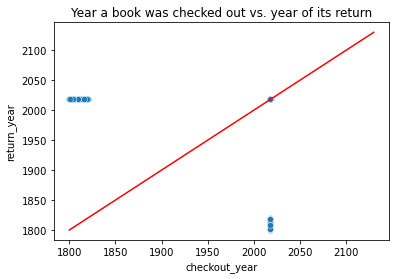

In [15]:
sns.scatterplot(x='checkout_year', y='return_year', data=checkouts_df);
plt.plot(np.linspace(1800, 2130, 10), np.linspace(1800, 2130, 10), color='r');
plt.title('Year a book was checked out vs. year of its return');

In the plot above, values below the red line (45 degree line) indicate errors as these are books that were returned in an earlier year than the one in which they were borrowed. 

#### creating a duration_borrowed variable 
which records how many days a book was borrowed for. This variable can also be used to examine erroneous records as it will be negative when date_returned is earlier than date_borrowed. 

In [16]:
checkouts_df['duration_borrowed'] = checkouts_df['date_returned'] - checkouts_df['date_checkout']

dropping observations where "duration_borrowed" is negative

In [17]:
checkouts_df = checkouts_df[checkouts_df['duration_borrowed']>=pd.Timedelta(0, unit='d')]

#### indicator variable for late returns 

In [18]:
checkouts_df['late_return_indicator'] = np.where(checkouts_df['duration_borrowed']>pd.Timedelta(28, unit='d'), 1, 0) 

#### inspecting observations where a book was borrowed for over a year

In [19]:
long_borrowed_df = checkouts_df[checkouts_df['duration_borrowed']>=pd.Timedelta(365, unit='d')]
long_borrowed_df.describe()

,checkout_year,return_year,duration_borrowed,late_return_indicator
count,90.000000,90.000000,90,90.0
mean,1809.533333,2018.055556,76151 days 06:08:00.000001024,1.0
std,6.193872,0.230345,2250 days 00:29:38.714858816,0.0
min,1800.000000,2018.000000,72188 days 00:00:00,1.0
25%,1804.000000,2018.000000,74158 days 12:00:00,1.0
50%,1809.000000,2018.000000,76317 days 12:00:00,1.0
75%,1815.000000,2018.000000,78095 days 18:00:00,1.0
max,1820.000000,2019.000000,79621 days 00:00:00,1.0


- There are 90 books that were borrowed for over a year
- All 90 of these books were borrowed for over 150 years
- All 90 of these books were borrowed in early 1800s and returned in 2018 and 2019 

In [20]:
# checking if all of these 90 books were returned to the same library 
# maybe a particular branch undertook retrieval of old books 
long_borrowed_df.library_id.nunique()

18

In [21]:
long_borrowed_df.library_id.value_counts()

228-222@5xc-jtz-hwk    8
zzw-222@5xc-jv4-789    8
22c-222@5xc-jwj-pvz    8
zzw-223@5xc-jv7-ct9    7
222-222@5xc-jvf-skf    7
222-222@5xc-jv5-nt9    6
zzw-222@5xc-knn-c5z    5
23v-222@5xc-jv7-v4v    5
22d-222@5xc-kcy-8sq    5
zzw-224@5xc-jwv-2rk    5
224-222@5xc-jw2-t9z    4
227-222@5xc-jww-btv    4
222-222@5xc-jxp-rp9    4
226-222@5xc-kc4-fpv    4
223-222@5xc-jxr-tgk    4
222-222@5xc-kkw-bzf    3
226-222@5xc-jxj-7yv    2
225-222@5xc-jtz-hkf    1
Name: library_id, dtype: int64

- The 90 books were returned across different library branches

In [22]:
# checking if all of these books were borrowed by the same patron 
# hypothesis being maybe a grandchild of the patron inherited the loaned books and returned them
long_borrowed_df.patron_id.nunique()

90

- Each of the 90 books were checked out by different patrons

In [23]:
long_borrowed_df.id.nunique()

73

#### inspecting observations where a book was borrowed for less than a year 

In [24]:
checkouts_df[checkouts_df['duration_borrowed']<=pd.Timedelta(365, unit='d')].describe()

,checkout_year,return_year,duration_borrowed,late_return_indicator
count,1451.0,1451.000000,1451,1451.000000
mean,2018.0,2018.064094,24 days 02:48:42.674017918,0.090972
std,0.0,0.245004,29 days 20:20:39.832183834,0.287668
min,2018.0,2018.000000,5 days 00:00:00,0.000000
25%,2018.0,2018.000000,11 days 00:00:00,0.000000
50%,2018.0,2018.000000,17 days 00:00:00,0.000000
75%,2018.0,2018.000000,23 days 00:00:00,0.000000
max,2018.0,2019.000000,179 days 00:00:00,1.000000


- books not borrowed in the 1800s are typically returned within 24 days

In [25]:
late_returns = checkouts_df[(checkouts_df['duration_borrowed']>pd.Timedelta(28, unit='d')) & (checkouts_df['duration_borrowed']<=pd.Timedelta(365, unit='d'))]

In [26]:
late_returns.describe()

,checkout_year,return_year,duration_borrowed,late_return_indicator
count,132.0,132.000000,132,132.0
mean,2018.0,2018.310606,105 days 16:00:00,1.0
std,0.0,0.464505,45 days 06:08:49.389319664,0.0
min,2018.0,2018.000000,29 days 00:00:00,1.0
25%,2018.0,2018.000000,63 days 00:00:00,1.0
50%,2018.0,2018.000000,102 days 00:00:00,1.0
75%,2018.0,2019.000000,146 days 06:00:00,1.0
max,2018.0,2019.000000,179 days 00:00:00,1.0


### adding holidays to the dataset 
a hypothesis for late returns is that the due date falls on or near a holiday, when patrons might be out of town or more likely to be otherwise occupied

In [27]:
checkouts_df['date_due'] = checkouts_df['date_checkout'] + pd.Timedelta(28, unit='d')

In [68]:
import holidays
us_holidays = []
for date in holidays.US(years=checkouts_df['date_due'].apply(lambda x: int(x.year)).unique()).items(): 
    us_holidays.append(date[0])
us_holidays = [pd.to_datetime(x) for x in us_holidays]

- we don't have data on holidays in the 1800s, which might be less relevant anyway 

In [59]:
checkouts_df['due_date_is_holiday'] = np.where(checkouts_df['date_due'].isin(us_holidays), 1, 0)

In [62]:
#proportion of late returns whose due date falls on a holiday 
checkouts_df[(checkouts_df['duration_borrowed']>pd.Timedelta(28, units='d'))&(checkouts_df['checkout_year']>2017)].due_date_is_holiday.value_counts()

0    1401
1      50
Name: due_date_is_holiday, dtype: int64

In [72]:
def days_from_closest_holiday(date, holiday_list): 
    "This function returns the number of days between a given date and a given list of holidays"
    holiday_distance_list = [abs(date-x) for x in holiday_list]
    smallest_distance = min(holiday_distance_list)
    return smallest_distance

In [73]:
checkouts_df['closest_holiday_distance'] = checkouts_df['date_due'].apply(lambda x: days_from_closest_holiday(x, us_holidays))

In [74]:
checkouts_df

,id,patron_id,library_id,date_checkout,date_returned,checkout_year,return_year,duration_borrowed,late_return_indicator,date_due,due_date_is_holiday,closest_holiday_distance
1,HUX-y4oXl04C,8d3f63e1deed89d7ba1bf6a4eb101373,223-222@5xc-jxr-tgk,2018-05-29,2018-06-12,2018,2018,14 days,0,2018-06-26,0,8 days
2,TQpFnkku2poC,4ae202f8de762591734705e0079d76df,228-222@5xc-jtz-hwk,2018-11-23,2019-01-24,2018,2019,62 days,1,2018-12-21,0,4 days
3,OQ6sDwAAQBAJ,f9372de3c8ea501601aa3fb59ec0f524,23v-222@5xc-jv7-v4v,2018-01-15,2018-04-25,2018,2018,100 days,1,2018-02-12,0,7 days
6,CW-7tHAaVR0C,dd9f34e9d65126a2b02003d8ac60aaa4,22c-222@5xc-jwj-pvz,2018-01-10,2018-02-04,2018,2018,25 days,0,2018-02-07,0,12 days
8,t1e3BWziAc8C,3b85b2c7b424618f533329018e9a11d5,222-222@5xc-jv5-nt9,2018-06-23,2018-07-14,2018,2018,21 days,0,2018-07-21,0,17 days
...,...,...,...,...,...,...,...,...,...,...,...,...
1995,rNbuDwAAQBAJ,91871955f3641857832766ac3f5a0b95,222-222@5xc-jv5-nt9,2018-07-19,2018-08-12,2018,2018,24 days,0,2018-08-16,0,18 days
1996,rcrCAgAAQBAJ,ad08956eb20efb746af650f906d439cf,22d-222@5xc-kcy-8sq,2018-03-07,2018-03-13,2018,2018,6 days,0,2018-04-04,0,44 days
1997,F44fAQAAMAAJ,026262cc3454149303074c4113b5f118,226-222@5xc-jxj-7yv,2018-06-17,2018-06-27,2018,2018,10 days,0,2018-07-15,0,11 days
1998,Ci1HAQAAMAAJ,08b29865e58e9b2aabff9684a703acf0,223-222@5xc-jxr-tgk,2018-12-10,2018-12-29,2018,2018,19 days,0,2019-01-07,0,6 days


*NOTES TO SELF:*
- plot holiday distance between late returns and non-late returns 
- move on after that 